In [1]:
import os
os.chdir('../..')
!ls

product_impacts


python(95886) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [2]:
import os.path
import pandas as pd
from skimpy import skim
import requests
from bs4 import BeautifulSoup
import statistics
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, mean_squared_error, r2_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from hiclass import LocalClassifierPerParentNode, LocalClassifierPerLevel

from product_impacts.product_cat.run_model import get_store, get_ndns_cats, get_products, get_ndns_matches, get_tsne

import numpy as np
import pickle
import json

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

sns.set()

python(95939) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.environ["RAY_ENABLE_MAC_LARGE_OBJECT_STORE"] = "1"

In [5]:
ndns = get_ndns_cats('../../SFS/NDNS UK/ndns_edited.csv')
products = get_products()
labelled_data, non_food_products = get_ndns_matches(
    ndns, products)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
# removing duplicated product names + ingredients (basically products with same exact feature vectors)
labelled_data['product_list_name_lower'] = labelled_data['product_list_name'].str.lower()
labelled_data['ingredients_text_lower'] = labelled_data['ingredients_text'].str.lower()
labelled_data = labelled_data.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [7]:
# lev 0 predictions
predicted_data = pd.read_csv('../../SFS/NDNS UK/predictions/predictions_lev0_manuallabels_nonHI_RF_withcorrections_14Oct2024.csv')

In [8]:
predicted_data.shape

(262711, 11)

In [9]:
predicted_data['parentcategory_pred'].value_counts()

Cereals and Cereal Products             52426
Miscellaneous                           27598
Meat and Meat Products                  26837
Non-Alcoholic Beverages                 25994
Sugar, Preserves and Confectionery      25822
Vegetables, Potatoes                    23757
Milk and Milk Products                  23239
Alcoholic Beverages                     15150
Fish and Fish Dishes                     9302
Fruit                                    7343
Savoury Snacks                           6460
Not Food                                 5086
Nuts and Seeds                           5057
Fat Spreads                              3811
Commercial Toddlers Foods and Drinks     2488
Eggs and Egg Dishes                      1315
Dietary Supplements                       622
Artificial Sweeteners                     404
Name: parentcategory_pred, dtype: int64

In [10]:
pred = predicted_data[predicted_data['parentcategory_pred']=='Fat Spreads'].reset_index(drop=True)
lab = labelled_data[(labelled_data['parentcategory']=='Fat Spreads')
                           & (labelled_data['subfoodgroupdesc'].notnull())].reset_index(drop=True)
lab = lab.merge(pred[['product_id']])

In [11]:
pred.shape

(3811, 11)

In [12]:
lab.shape

(1147, 12)

In [13]:
lab['subfoodgroupdesc'].value_counts()

Other cooking fats and oils not polyunsaturated    489
Butter                                             171
Reduced fat spread (not polyunsaturated)           145
Polyunsaturated oils                               102
Block margarine                                     78
Polyunsaturated low fat spread                      71
Reduced fat spread (polyunsaturated)                42
Polyunsaturated margarine                           38
Low fat spread not polyunsaturated                  11
Name: subfoodgroupdesc, dtype: int64

In [14]:
lab['mainfoodgroupdesc'].value_counts()

Margarine and other cooking fats and oils not Polyunsaturated    567
Reduced fat spread                                               187
Butter                                                           171
Polyunsaturated margarine and oils                               140
Low fat spread                                                    82
Name: mainfoodgroupdesc, dtype: int64

In [15]:
pred['subfoodgroup_lab'].value_counts()

Other cooking fats and oils not polyunsaturated    489
Butter                                             171
Reduced fat spread (not polyunsaturated)           145
Polyunsaturated oils                               102
Block margarine                                     78
Polyunsaturated low fat spread                      71
Reduced fat spread (polyunsaturated)                42
Polyunsaturated margarine                           38
Low fat spread not polyunsaturated                  11
Nutrition powders and drinks                         1
Other vegetables                                     1
Other cheese                                         1
Name: subfoodgroup_lab, dtype: int64

In [16]:
lev2_labels_add = pred[[
    'product_id', 'product_list_name', 'product_name', 'ingredients_text', 'store']]
lev2_labels_add['parentcategory'] = 'Fat Spreads'
lev2_labels_add['subfoodgroupdesc'] = np.NaN

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("hemp seed oil")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("hempseed oil")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("wok oil")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("grapeseed oil")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("flaxseed oil")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sesame oil")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sunflower oil cooking spray")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cooking spray"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("butter")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("frylight"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("butter")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cooking spray"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("garlic")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("vegetable oil"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("ktc")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mustard oil")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sunflower & extra virgin olive oil")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sunolive oil")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("groovy food co. omega high five cooking oil")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("walnut oil")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("groundnut oil")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("rice bran oil")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("udo's choice")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("lee kum kee")),
                    'subfoodgroupdesc'] = 'Polyunsaturated oils'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cooking spray"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("sunflower"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("butter"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("garlic")),
                    'subfoodgroupdesc'] = 'Other cooking fats and oils not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mct oil")),
                    'subfoodgroupdesc'] = 'Other cooking fats and oils not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("essential vegetable oil")),
                    'subfoodgroupdesc'] = 'Other cooking fats and oils not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("hazelnut oil")),
                    'subfoodgroupdesc'] = 'Other cooking fats and oils not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("dripping")),
                    'subfoodgroupdesc'] = 'Other cooking fats and oils not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("carotino healthier oil")),
                    'subfoodgroupdesc'] = 'Other cooking fats and oils not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("frylight coconut oil")),
                    'subfoodgroupdesc'] = 'Other cooking fats and oils not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("rapeseed oil"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("grape"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("butter"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("spread")),
                    'subfoodgroupdesc'] = 'Other cooking fats and oils not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("vegetable oil"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("ktc"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("puree")),
                    'subfoodgroupdesc'] = 'Other cooking fats and oils not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("ghee easy")),
                    'subfoodgroupdesc'] = 'Other cooking fats and oils not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("solid cooking oil")),
                    'subfoodgroupdesc'] = 'Other cooking fats and oils not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("coconut"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("butter")),
                    'subfoodgroupdesc'] = 'Other cooking fats and oils not polyunsaturated'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("lurpak"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("anchor"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("kerrymaid dairy spread")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco butterpak")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("buttersoft light")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("clover lighter")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("norpak lighter")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco buttery spread"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("less")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco gold spread"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("light")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco soft baking spread")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("kerry low low")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("stockwell & co. soft spread")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("m savers soft spread")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("morrisons spreadable"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("reduced")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("asda brilliantly buttery")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco butter me up")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (not polyunsaturated)'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco olive"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread")),
                    'subfoodgroupdesc'] = 'Low fat spread not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco buttery spread"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("less")),
                    'subfoodgroupdesc'] = 'Low fat spread not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco gold spread"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light")),
                    'subfoodgroupdesc'] = 'Low fat spread not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light olive"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread")),
                    'subfoodgroupdesc'] = 'Low fat spread not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("violife"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light")),
                    'subfoodgroupdesc'] = 'Low fat spread not polyunsaturated'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sunflower spread"))
                    & ((lev2_labels_add['product_list_name'].str.lower().str.contains("pure"))
                      | (lev2_labels_add['product_list_name'].str.lower().str.contains("morrisons"))),
                    'subfoodgroupdesc'] = 'Reduced fat spread (polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("country life"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("bertolli original"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("bertolli olive oil"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("light"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("flora pro"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("buttery")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("flora light vegan")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pure dairy free"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("olive")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("vitalite dairy free")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("koko dairy free")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("i can't believe"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("light")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("waitrose light spread")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (polyunsaturated)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("utterly butterly"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("light")),
                    'subfoodgroupdesc'] = 'Reduced fat spread (polyunsaturated)'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("bertolli olive oil"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread")),
                    'subfoodgroupdesc'] = 'Polyunsaturated low fat spread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("flora pro"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("olive")),
                    'subfoodgroupdesc'] = 'Polyunsaturated low fat spread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("flora pro"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light")),
                    'subfoodgroupdesc'] = 'Polyunsaturated low fat spread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("flora lighter")),
                    'subfoodgroupdesc'] = 'Polyunsaturated low fat spread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("i can't believe"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light")),
                    'subfoodgroupdesc'] = 'Polyunsaturated low fat spread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("free dairy and gluten free")),
                    'subfoodgroupdesc'] = 'Polyunsaturated low fat spread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("utterly butterly"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light")),
                    'subfoodgroupdesc'] = 'Polyunsaturated low fat spread'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("président"))
                    | (lev2_labels_add['product_list_name'].str.lower().str.contains("president")),
                    'subfoodgroupdesc'] = 'Butter'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("morrisons spreadable"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("reduced")),
                    'subfoodgroupdesc'] = 'Butter'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("country life"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("spread")),
                    'subfoodgroupdesc'] = 'Butter'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("violife"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("light")),
                    'subfoodgroupdesc'] = 'Block margarine'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pure dairy free"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("alternative")),
                    'subfoodgroupdesc'] = 'Block margarine'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("naturli"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("block")),
                    'subfoodgroupdesc'] = 'Block margarine'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("flora"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("spread"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("alternative")),
                    'subfoodgroupdesc'] = 'Block margarine'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tomor"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("block")),
                    'subfoodgroupdesc'] = 'Block margarine'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("naturli"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread")),
                    'subfoodgroupdesc'] = 'Soft margarine not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("homepride baking")),
                    'subfoodgroupdesc'] = 'Soft margarine not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("stork spread")),
                    'subfoodgroupdesc'] = 'Soft margarine not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("stork original spread")),
                    'subfoodgroupdesc'] = 'Soft margarine not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("willow original")),
                    'subfoodgroupdesc'] = 'Soft margarine not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("morrisons soft"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread")),
                    'subfoodgroupdesc'] = 'Soft margarine not polyunsaturated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco baking spread")),
                    'subfoodgroupdesc'] = 'Soft margarine not polyunsaturated'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("flora"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spread"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("alternative")),
                    'subfoodgroupdesc'] = 'Polyunsaturated margarine'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("flora buttery spread")),
                    'subfoodgroupdesc'] = 'Polyunsaturated margarine'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("flora dairy free spread")),
                    'subfoodgroupdesc'] = 'Polyunsaturated margarine'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("flora original spread")),
                    'subfoodgroupdesc'] = 'Polyunsaturated margarine'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("plant kitchen sunflower spread")),
                    'subfoodgroupdesc'] = 'Polyunsaturated margarine'

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A val

In [17]:
# lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("lee kum kee"))
#                    ]

In [18]:
lev2_labels_add = lev2_labels_add.merge(
    ndns.drop('detaileddesc', axis=1)).drop_duplicates(subset=['product_id', 'subfoodgroupdesc'])
lev2_labels_add['product_list_name_lower'] = lev2_labels_add['product_list_name'].str.lower()
lev2_labels_add['ingredients_text_lower'] = lev2_labels_add['ingredients_text'].str.lower()
lev2_labels_add = lev2_labels_add.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

dups = lab[['product_id', 'product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']].merge(
    lev2_labels_add[['product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']])['product_id'].values
lev2_labels_add = lev2_labels_add[(~lev2_labels_add['product_id'].isin(dups))]
lab = lab[(~lab['product_id'].isin(lev2_labels_add['product_id'].values))]
lab = pd.concat([lab, lev2_labels_add], ignore_index=True, axis=0).drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [19]:
lab.shape

(1460, 12)

In [20]:
lab['subfoodgroupdesc'].value_counts()

Other cooking fats and oils not polyunsaturated    596
Reduced fat spread (not polyunsaturated)           214
Polyunsaturated oils                               183
Butter                                             171
Reduced fat spread (polyunsaturated)               114
Polyunsaturated low fat spread                      69
Block margarine                                     46
Polyunsaturated margarine                           36
Soft margarine not polyunsaturated                  20
Low fat spread not polyunsaturated                  11
Name: subfoodgroupdesc, dtype: int64

In [21]:
pred = pred.drop('mainfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'mainfoodgroupdesc']], how='left').rename(columns={'mainfoodgroupdesc': 'mainfoodgroup_lab'})

pred = pred.drop('subfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'subfoodgroupdesc']], how='left').rename(columns={'subfoodgroupdesc': 'subfoodgroup_lab'})

In [22]:
query_embeddings = np.load('../../SFS/bert/all_embeddings_all3.npy')
tsne_results = get_tsne(query_embeddings, '../../SFS/bert/tsne_results_all3.npy')
product_ids = np.load('../../SFS/bert/all_ids_all3.npy')

features = pd.DataFrame(data=query_embeddings)
id_col = 'product_id'
X_cols = features.columns.tolist()
y_cols = ['parentcategory', 'mainfoodgroupdesc', 'subfoodgroupdesc']

features['product_id'] = pd.Series(product_ids, index=features.index)
features[['tsne_0', 'tsne_1']] = tsne_results
lab = lab.merge(features)

In [27]:
acc_list_train = []
bal_acc_list_train = []
precision_list_train = []
recall_list_train = []
f1_list_train = []
mcc_list_train = []

acc_list_test = []
bal_acc_list_test = []
precision_list_test = []
recall_list_test = []
f1_list_test = []
mcc_list_test = []

for i in range(1):
    train, test = train_test_split(lab, test_size=0.2, random_state=i)
    print(f'Number of unique level 1 categories in train: {train[y_cols[1]].nunique()}')
    print(f'Number of unique level 1 categories in test: {test[y_cols[1]].nunique()}')
    print(f'Number of unique level 2 categories in train: {train[y_cols[2]].nunique()}')
    print(f'Number of unique level 2 categories in test: {test[y_cols[2]].nunique()}\n')

    X_train = train[X_cols]
    y_train = train[[y_cols[1], y_cols[2]]]
    y_train1 = train[y_cols[1]]
    y_train2 = train[y_cols[2]]

    X_test = test[X_cols]
    y_test = test[[y_cols[1], y_cols[2]]]
    y_test1 = test[y_cols[1]]
    y_test2 = test[y_cols[2]]

    mod = RandomForestClassifier(n_estimators=400, 
                                 min_samples_leaf=10, 
                                 max_depth=25,
                                 class_weight='balanced'
                                )

    clf2 = mod
    clf2.fit(X_train, y_train2)
    y_train_pred2 = clf2.predict(X_train)
    y_test_pred2 = clf2.predict(X_test)

    y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
    y_test_pred1 = pd.DataFrame(y_test_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values

    print(f'Lev 1 train accuracy: {accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 train balanced accuracy: {balanced_accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 test accuracy: {accuracy_score(y_test1, y_test_pred1)}')
    print(f'Lev 1 test balanced accuracy: {balanced_accuracy_score(y_test1, y_test_pred1)}\n')

    print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 test accuracy: {accuracy_score(y_test2, y_test_pred2)}')
    print(f'Lev 2 test balanced accuracy: {balanced_accuracy_score(y_test2, y_test_pred2)}\n')

    print(f'Number of unique level 1 categories predicted in train: {len(np.unique(y_train_pred1))}')
    print(f'Number of unique level 1 categories predicted in test: {len(np.unique(y_test_pred1))}')    
    print(f'Number of unique level 2 categories predicted in train: {len(np.unique(y_train_pred2))}')
    print(f'Number of unique level 2 categories predicted in test: {len(np.unique(y_test_pred2))}\n')    
    
    acc_list_train.append(accuracy_score(y_train2, y_train_pred2))
    bal_acc_list_train.append(balanced_accuracy_score(y_train2, y_train_pred2))
    precision_list_train.append(precision_score(y_train2, y_train_pred2, average='weighted'))
    recall_list_train.append(recall_score(y_train2, y_train_pred2, average='weighted'))
    f1_list_train.append(f1_score(y_train2, y_train_pred2, average='weighted'))
    mcc_list_train.append(matthews_corrcoef(y_train2, y_train_pred2))
    
    acc_list_test.append(accuracy_score(y_test2, y_test_pred2))
    bal_acc_list_test.append(balanced_accuracy_score(y_test2, y_test_pred2))
    precision_list_test.append(precision_score(y_test2, y_test_pred2, average='weighted'))
    recall_list_test.append(recall_score(y_test2, y_test_pred2, average='weighted'))
    f1_list_test.append(f1_score(y_test2, y_test_pred2, average='weighted'))
    mcc_list_test.append(matthews_corrcoef(y_test2, y_test_pred2))

Number of unique level 1 categories in train: 5
Number of unique level 1 categories in test: 5
Number of unique level 2 categories in train: 10
Number of unique level 2 categories in test: 10

Lev 1 train accuracy: 0.961472602739726
Lev 1 train balanced accuracy: 0.9612321205677279
Lev 1 test accuracy: 0.8972602739726028
Lev 1 test balanced accuracy: 0.846864697802198

Lev 2 train accuracy: 0.9580479452054794
Lev 2 train balanced accuracy: 0.9580766988707557
Lev 2 test accuracy: 0.8835616438356164
Lev 2 test balanced accuracy: 0.8820026636123185

Number of unique level 1 categories predicted in train: 5
Number of unique level 1 categories predicted in test: 5
Number of unique level 2 categories predicted in train: 10
Number of unique level 2 categories predicted in test: 10



In [28]:
print('train')
print(f'accuracy: {statistics.mean(acc_list_train)}')
print(f'balanced accuracy: {statistics.mean(bal_acc_list_train)}')
print(f'precision: {statistics.mean(precision_list_train)}')
print(f'recall: {statistics.mean(recall_list_train)}')
print(f'f1: {statistics.mean(f1_list_train)}')
print(f'mcc: {statistics.mean(mcc_list_train)}')

print('test')
print(f'accuracy: {statistics.mean(acc_list_test)}')
print(f'balanced accuracy: {statistics.mean(bal_acc_list_test)}')
print(f'precision: {statistics.mean(precision_list_test)}')
print(f'recall: {statistics.mean(recall_list_test)}')
print(f'f1: {statistics.mean(f1_list_test)}')
print(f'mcc: {statistics.mean(mcc_list_test)}')

train
accuracy: 0.9580479452054794
balanced accuracy: 0.9580766988707557
precision: 0.9599367622382857
recall: 0.9580479452054794
f1: 0.9582979512450288
mcc: 0.9461993926377138
test
accuracy: 0.8835616438356164
balanced accuracy: 0.8820026636123185
precision: 0.8979246506988352
recall: 0.8835616438356164
f1: 0.8870923206100831
mcc: 0.85089796383658


In [24]:
X_train = lab[X_cols]
y_train = lab[[y_cols[1], y_cols[2]]]
y_train1 = lab[y_cols[1]]
y_train2 = lab[y_cols[2]]

pred = pred.drop(['tsne_0', 'tsne_1'], axis=1).merge(features)
X_pred = pred[X_cols]

mod = RandomForestClassifier(n_estimators=400, 
                             min_samples_leaf=10, 
                             max_depth=20,
                             class_weight='balanced')

clf2 = mod
clf2.fit(X_train, y_train2)
y_train_pred2 = clf2.predict(X_train)
y_pred2 = clf2.predict(X_pred)

y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
y_pred1 = pd.DataFrame(y_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values


print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')

print(f'Number of unique level 2 categories in train: {len(np.unique(y_train_pred2))}')
print(f'Number of unique level 2 categories in pred: {len(np.unique(y_pred2))}')    

pred['mainfoodgroup_pred'] = pd.Series(y_pred1, index = pred.index)
pred['subfoodgroup_pred'] = pd.Series(y_pred2, index = pred.index)

cols = ['product_id', 'product_name', 'product_list_name', 'store', 'ingredients_text',
        'parentcategory_lab', 'mainfoodgroup_lab', 'subfoodgroup_lab',
        'parentcategory_pred', 'mainfoodgroup_pred', 'subfoodgroup_pred', 'tsne_0', 'tsne_1']

pred = pred[cols]

print(pred[(pred['subfoodgroup_lab'].notnull()) & (pred['parentcategory_lab']==pred['parentcategory_pred'])
           & (pred['subfoodgroup_lab']!=pred['subfoodgroup_pred'])].shape)

Lev 2 train accuracy: 0.958904109589041
Lev 2 train balanced accuracy: 0.9590828367248253
Number of unique level 2 categories in train: 10
Number of unique level 2 categories in pred: 10
(52, 13)


In [25]:
pred['subfoodgroup_pred'].value_counts()

Other cooking fats and oils not polyunsaturated    1972
Butter                                              474
Polyunsaturated oils                                424
Reduced fat spread (not polyunsaturated)            355
Reduced fat spread (polyunsaturated)                225
Polyunsaturated low fat spread                      133
Block margarine                                     100
Polyunsaturated margarine                            78
Soft margarine not polyunsaturated                   31
Low fat spread not polyunsaturated                   19
Name: subfoodgroup_pred, dtype: int64

In [26]:
# the reduced fat cateogories can be confusing, especially for milk based buttery spreads 
#     (a lot of them have fat content less than 80% but im not sure they should be considered reduced fat)
# margarine vs reduced fat categories are also confusing
# what does high in polyunsaturated fats mean? I was quite non concervative with assigning polyunsaturated label 

In [ ]:
pred.sample(100)[['product_list_name', 'ingredients_text', 'subfoodgroup_lab', 'subfoodgroup_pred']].sort_values(by='subfoodgroup_pred').reset_index(drop=True)

In [28]:
# pred[pred['subfoodgroup_pred']=='Polyunsaturated margarine'].sort_values(by='product_list_name').reset_index(drop=True)

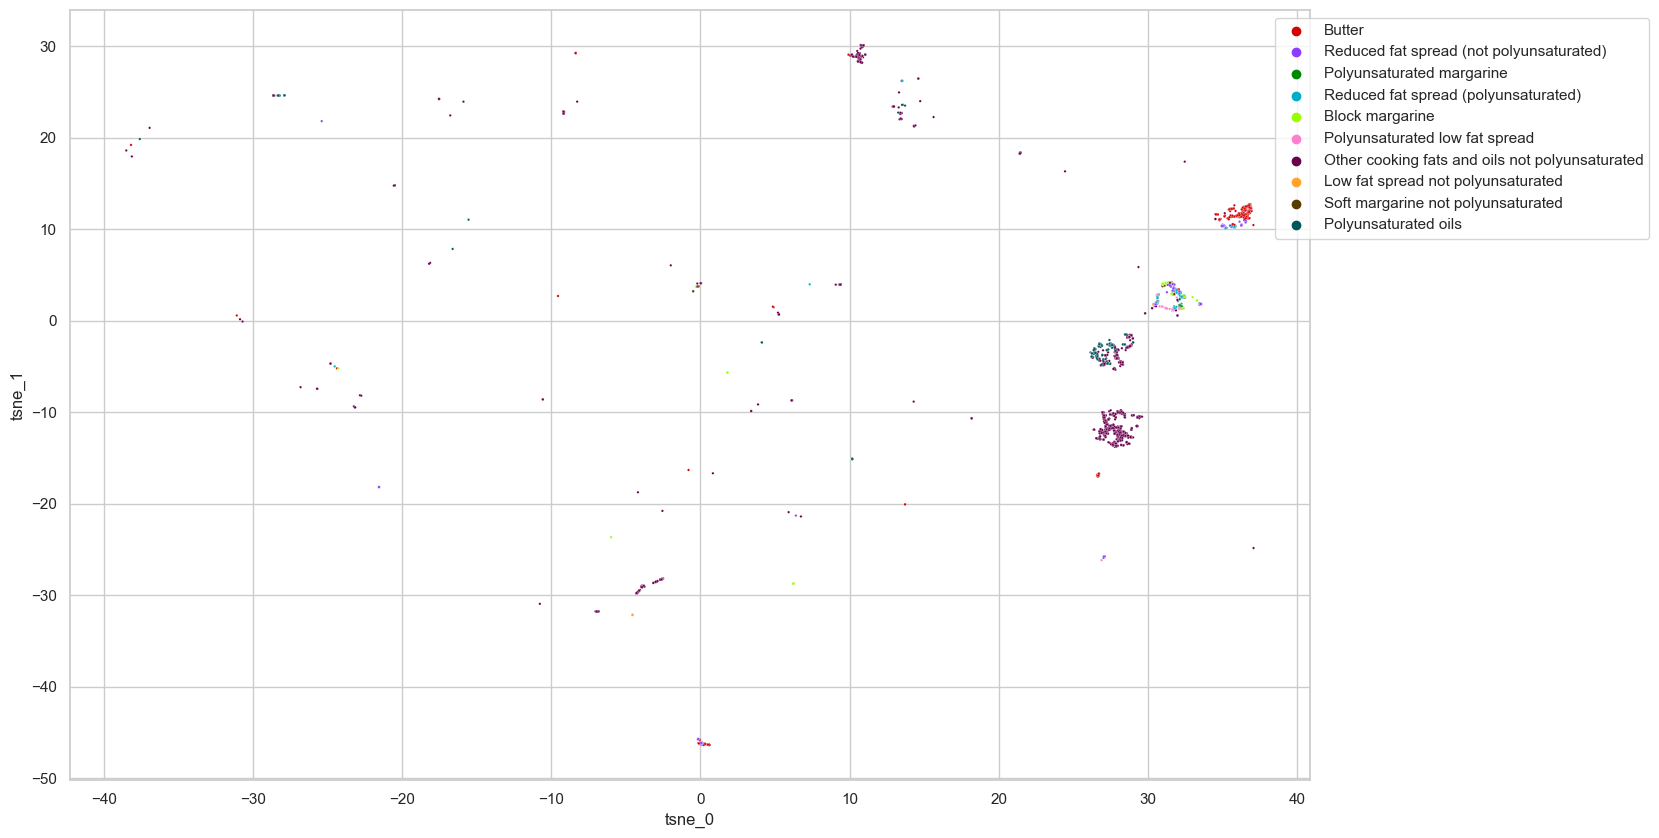

In [29]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pred['tsne_0'], y=pred['tsne_1'],
    hue=pred['subfoodgroup_pred'],
    palette=sns.color_palette(cc.glasbey, n_colors=pred['subfoodgroup_pred'].nunique()), s=3
)
plt.legend(bbox_to_anchor=(1.28, 1), loc='upper right')

In [30]:
# save level 2 cereal categories
pred.to_csv('../../SFS/NDNS UK/predictions/predictions_fats_lev2_manuallabels_nonHI_RF_15Oct2024.csv', 
                      index=False)